# Work on citation scraping for each opinions and try to create clusters of opinions based on spectral analysis of an opinions graph

In [2]:
from bs4 import BeautifulSoup
import pandas
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors
import networkx as nx
from numpy.linalg import eigh
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Import the opinions sample

In [28]:
opinions = pandas.read_csv("opinions_sample.csv", sep=";")
print(list(opinions))

['absolute_url', 'author', 'author_str', 'cluster', 'date_created', 'date_modified', 'download_url', 'extracted_by_ocr', 'html', 'html_lawbox', 'html_with_citations', 'joined_by', 'local_path', 'opinions_cited', 'per_curiam', 'plain_text', 'resource_uri']


In [4]:
columns = ['case_cite','parties','docket','court','date','intent']
extracted_data = pandas.DataFrame(columns=columns)

### Extract ids for each opinions

In [5]:
extraction = opinions.absolute_url.str.split('/',expand = True)
extracted_id = extraction[extraction.columns[2]]

### Scrap the HTML for each opinions in order to create a new data frame based on HTML class

In [6]:
missing_html=[]
for i in range(len(opinions.html)):
    case_cite, parties, docket, court, date, indent = (list(),)*6
    try:
        soup = BeautifulSoup(opinions.html[i],"html.parser")
        try:
            case_cite = soup.findAll("p", {"class": "case_cite"})
        except:
            print("No Case Cite")
        try:
            parties = soup.findAll("p", {"class": "parties"})
        except:
            print("No parties")
        try:
            docket = soup.findAll("p", {"class": "docket"})
        except:
            print("No docket")
        try:
            court = soup.findAll("p", {"class": "court"})
        except:
            print("No court")
        try:
            date = soup.findAll("p", {"class": "date"})
        except:
            print("No date")
        try:
            indent = soup.findAll("p", {"class": "indent"})
        except:
            print("No indent")
        extracted_data.loc[i] = [[obs.get_text() for obs in case_cite],[obs.get_text() for obs in parties],[obs.get_text() for obs in docket],[obs.get_text() for obs in court],[obs.get_text() for obs in date],[obs.get_text() for obs in indent]]
    except:
        missing_html.append(i)

### Assign the ID for each observation

In [7]:
extracted_data = extracted_data.assign(id = extracted_id)
extracted_data.head()
extracted_data.case_cite = [[id.split()[0] for id in case] for case in extracted_data.case_cite]

### Create a sub dataframe with id and case cited

In [8]:
int_list = []
for index, element in extracted_data.iterrows():
    try :
        int_list.append(list(map(int, element.case_cite)))
    except:
        int_list.append([])
extracted_data.case_cite = int_list
case_relation = pandas.concat([extracted_data.id, extracted_data.case_cite], axis = 1)

In [9]:
case_relation.head()

,id,case_cite
0,143119,[544]
1,122028,[536]
2,92451,"[130, 9, 32]"
3,134300,[540]
5,89793,"[97, 24]"


### Create a graph based on relation between cases

In [10]:
case_cite_graph = nx.DiGraph()

for index, element in case_relation.iterrows():
    case_cite_graph.add_node(element.id, attr_dict={"is_case": True})
    for link in element.case_cite:
        case_cite_graph.add_node(link, attr_dict={"is_case": False})
        case_cite_graph.add_edge(element.id, link)

(-0.10486286401748657, 1.103556807041168, -0.10500000000000001, 1.105)

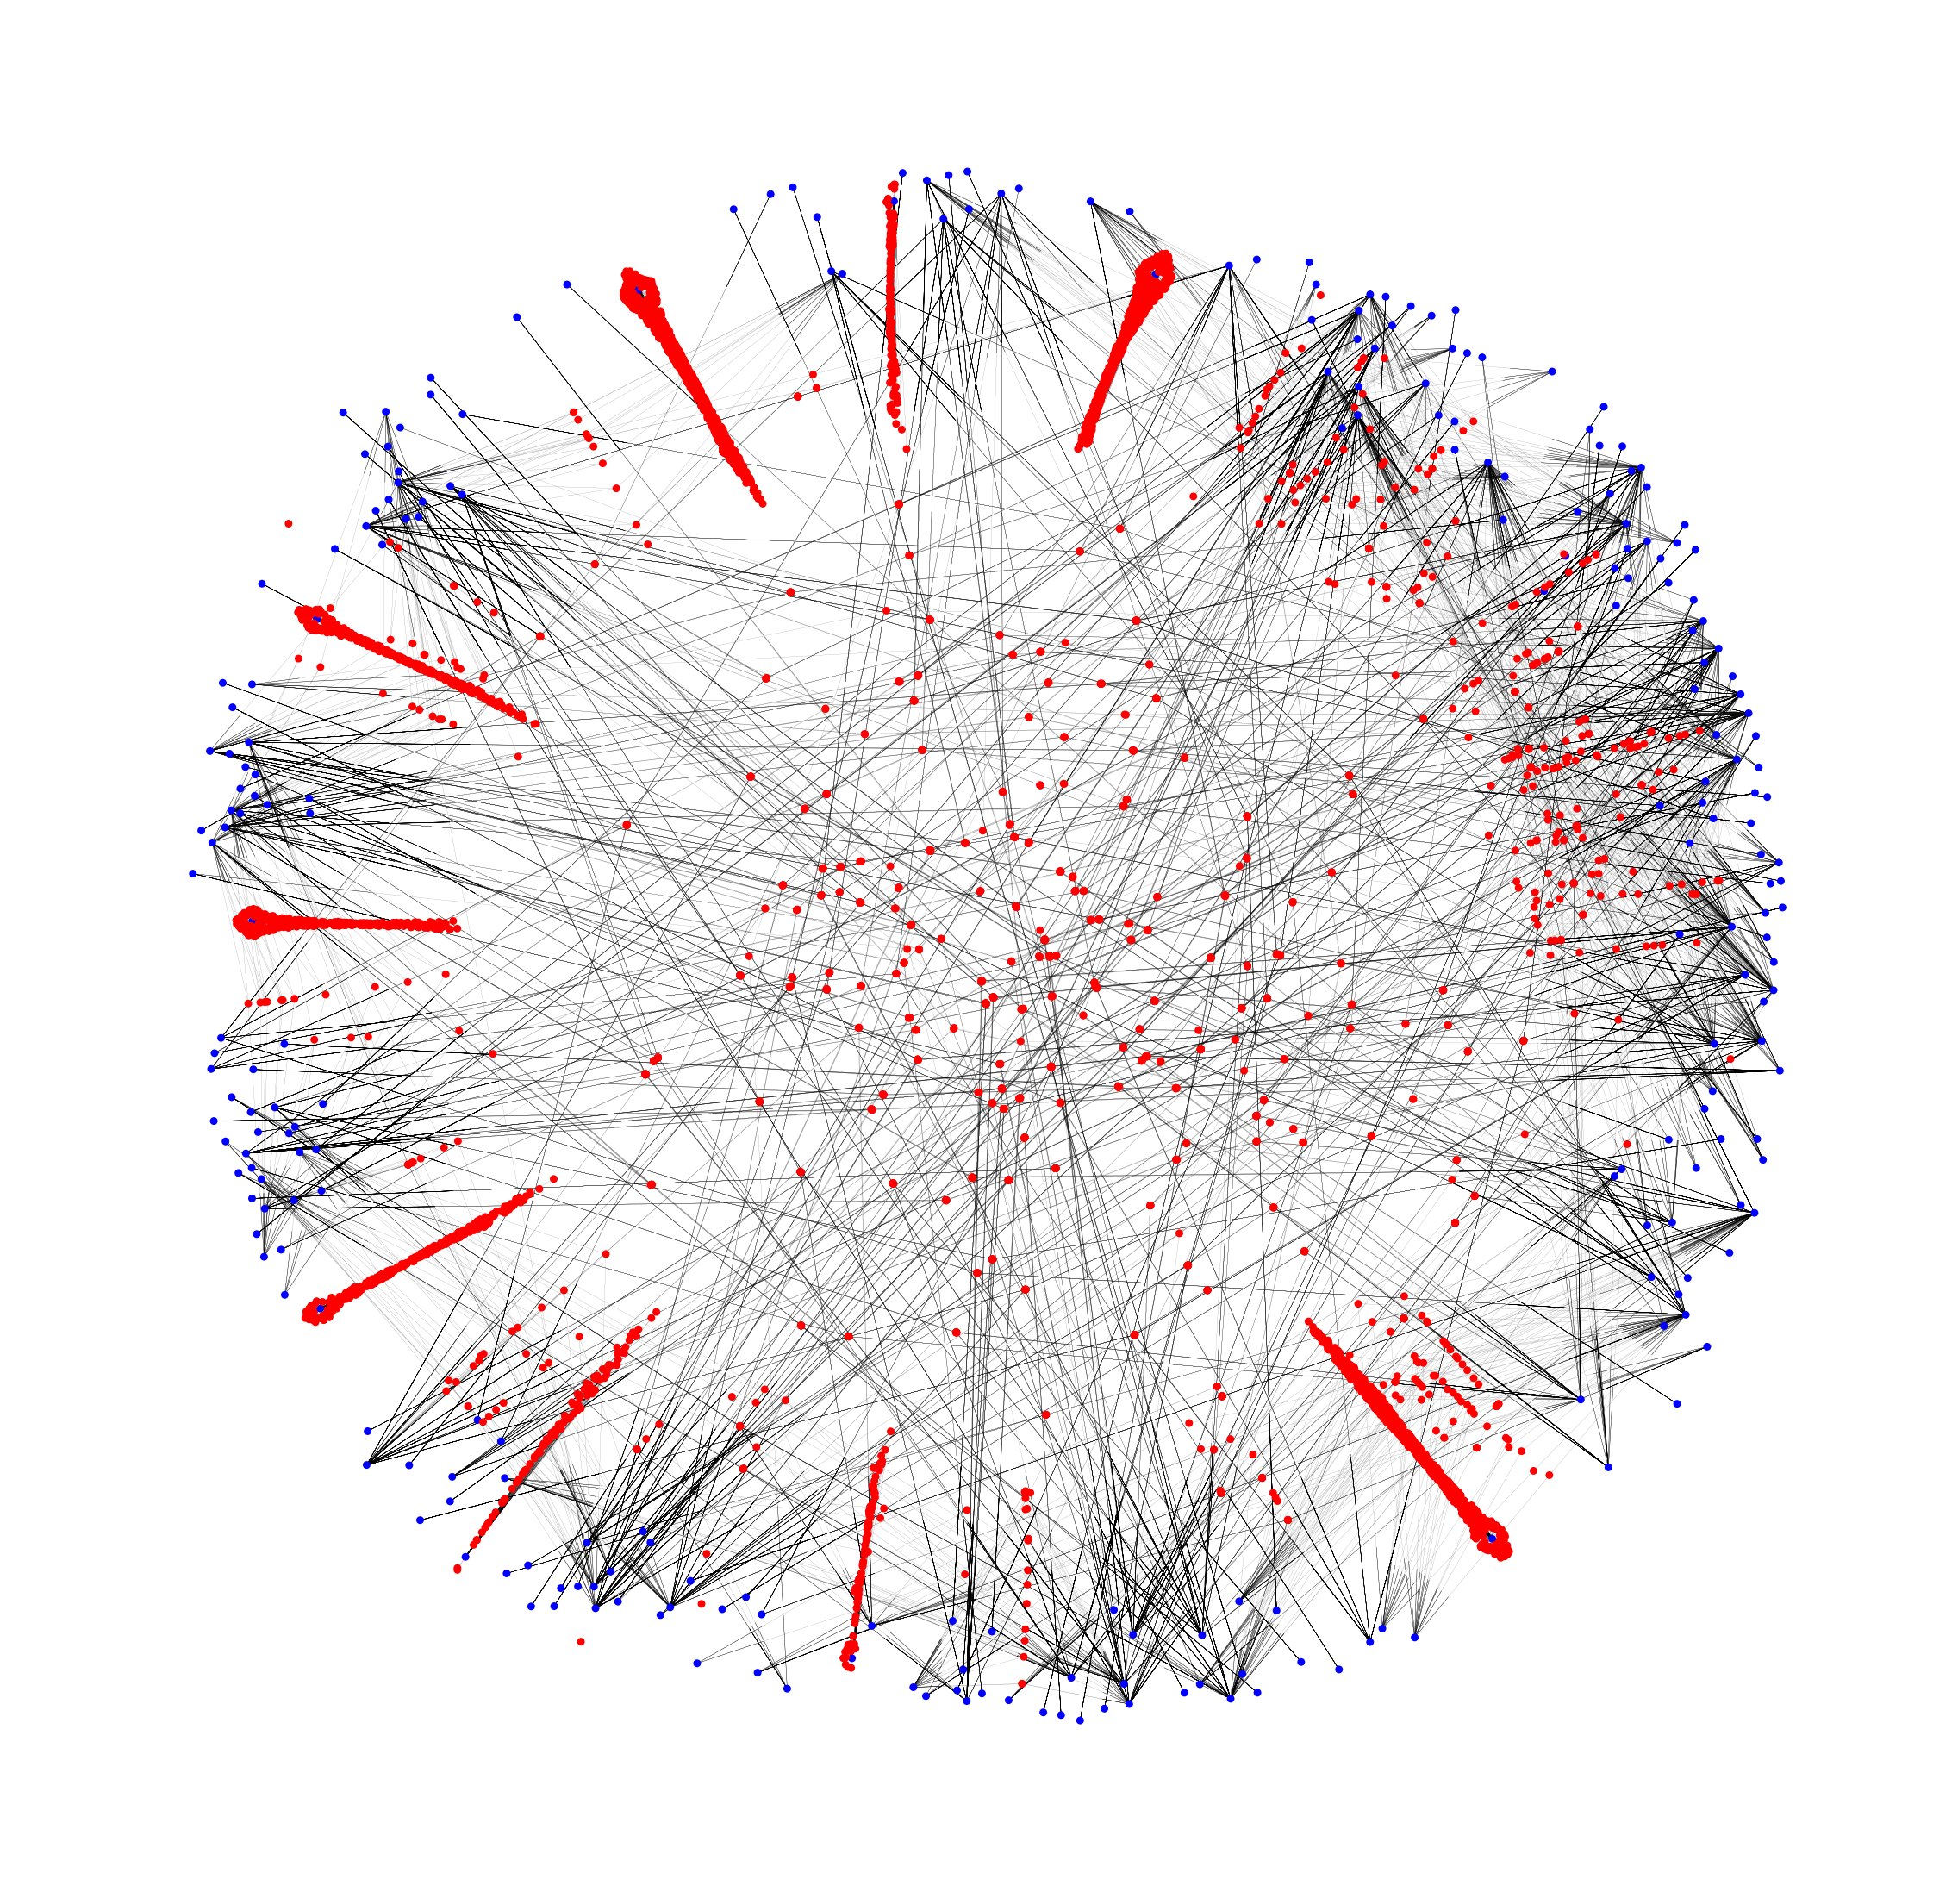

In [11]:
%matplotlib inline
plt.figure(figsize=(40,40))
colors = ['r' if case_cite_graph.node[n]['is_case'] else 'b' for n in case_cite_graph]
nx.draw_networkx(case_cite_graph, node_size=80, pos = nx.spring_layout(case_cite_graph), node_color=colors, linewidths=0, width=0.1, with_labels = False)
plt.axis('off')

### Laplacian matrix and spectral clustering of the graph

In [12]:
laplacian = nx.directed_laplacian_matrix(case_cite_graph)

In [13]:
eig_vals, eig_vectors = eigh(laplacian.A)

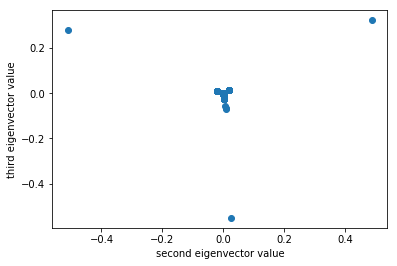

In [14]:
plt.figure()
plt.plot(eig_vectors[:,1], eig_vectors[:,2],'o')
plt.xlabel('second eigenvector value')
plt.ylabel('third eigenvector value')
plt.show()

In [15]:
X = np.array(list(zip(eig_vectors[:,1], eig_vectors[:,2])))

### Eclust analysis of the clustering

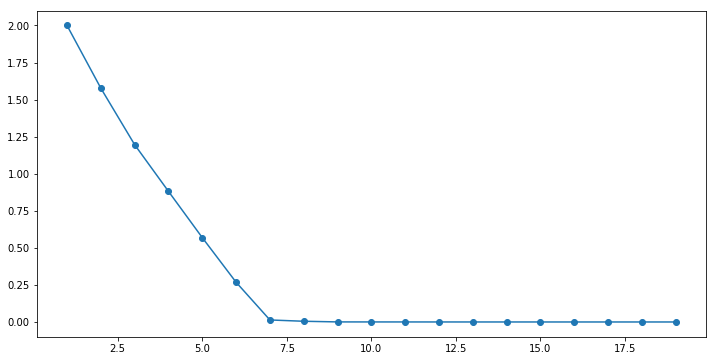

In [16]:
cluster_range = range(1, 20)
cluster_errors = []
for num_clusters in cluster_range:
    kmean = KMeans(num_clusters)
    kmean.fit(X)
    cluster_errors.append(kmean.inertia_)

clusters_df = pandas.DataFrame({ "num_clusters":cluster_range, "cluster_errors": cluster_errors })
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [17]:
clusters_df

,cluster_errors,num_clusters
0,1.999992,1
1,1.577049,2
2,1.195764,3
3,0.881070,4
4,0.568889,5
5,0.267930,6
6,0.013577,7
7,0.004805,8
8,0.000421,9
9,0.000251,10


### Apply K-means to the dataset 

In [18]:
kmeans = KMeans(n_clusters=7)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_
labels

array([0, 2, 0, ..., 2, 0, 2], dtype=int32)

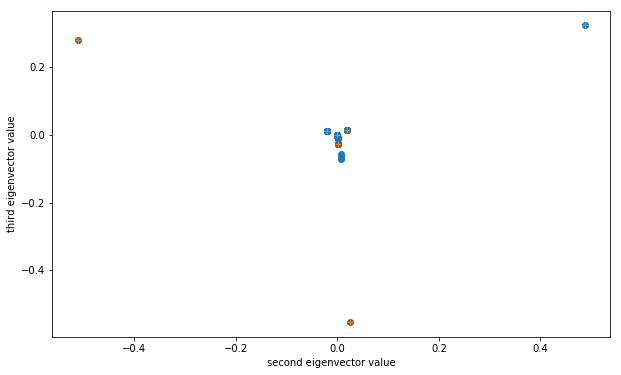

In [19]:
plt.figure(figsize=(10,6))
plt.plot(eig_vectors[:,1], eig_vectors[:,2],'o')
plt.plot(centroids[:,0], centroids[:,1],'+')
plt.xlabel('second eigenvector value')
plt.ylabel('third eigenvector value')
plt.show()

In [20]:
print(len(case_cite_graph.nodes()))
print(len(labels))

4924
4924


In [67]:
len(missing_html)

345

### Assign cluster ID to the dataset 

In [23]:
for i in range(len(labels)):
    if nodes[i] in list(map(int, case_cite_graph.nodes())):
        mask = case_relation.id.astype('int64') == nodes[i]
        case_relation.loc[mask, 'cluster_id'] = labels[i]

In [30]:
case_relation.head()

,id,case_cite,cluster_id
0,143119,[544],0.0
1,122028,[536],0.0
2,92451,"[130, 9, 32]",0.0
3,134300,[540],2.0
5,89793,"[97, 24]",0.0
